1.  Возьмите из прошлого домашнего задания ряд — стационарный и не стационарный.
2.  Приблизьте оба варианта моделями из класса MA.
3.  Оцените качество и пришлите соображения, почему была выбрана та или иная модель.

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox

## Functions

In [3]:
def tsplot(y, lags=None, figsize=(10, 6), style='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y,
                               lags=lags,
                               ax=pacf_ax,
                               alpha=0.05,
                               method='ywm')

        plt.tight_layout()
    return

In [4]:
def rmse(series1, series2):
    res = []
    # assert(series1 != series2):

    # print('series should have same sizes')
    for i, ser in enumerate(series1):
        res.append(np.sqrt((list(series1)[i] - list(series2)[i])**2))
    return (np.round(sum(res), 5))

## Load data

In [5]:
# Загрузим стационарный и нестационарный ряды
stat_df = pd.read_csv("Series\daily-total-female-births-in-cal.csv",
                      parse_dates=[0],
                      index_col=0)

non_stat_df = pd.read_csv('Series\monthly-sales-of-company-x-jan-6.csv',
                          parse_dates=[0],
                          index_col=0)


## Приближение стационарного ряда моделями скользящего среднего взвешенного

In [183]:
stat_ser = stat_df.reset_index().iloc[:,-1]

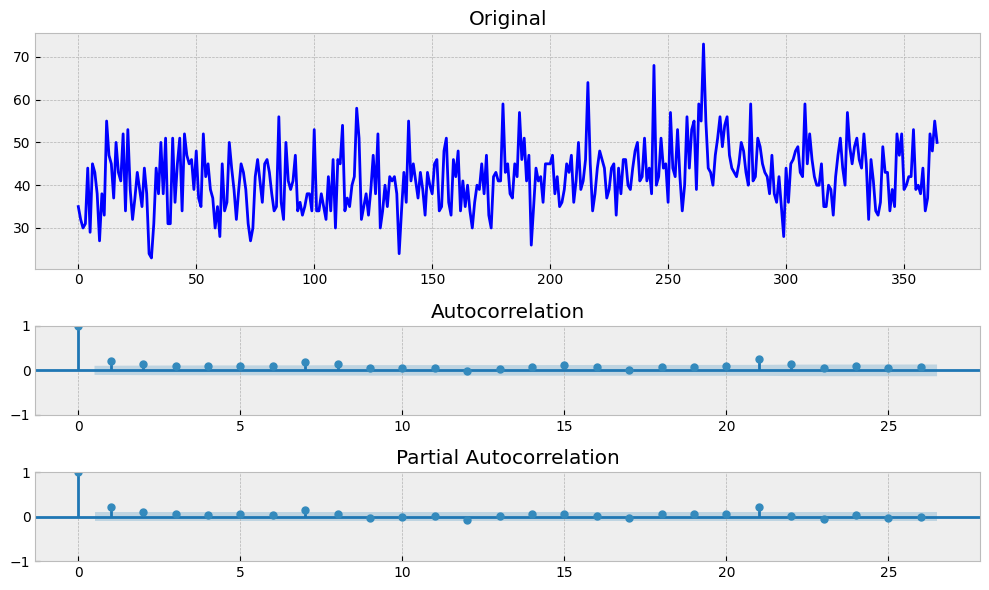

In [184]:
# Рассмотрим ряд. как мы знаем из прошлого дз, он стационарный, то можем проверить простую модель WMA

tsplot(stat_ser)

In [185]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

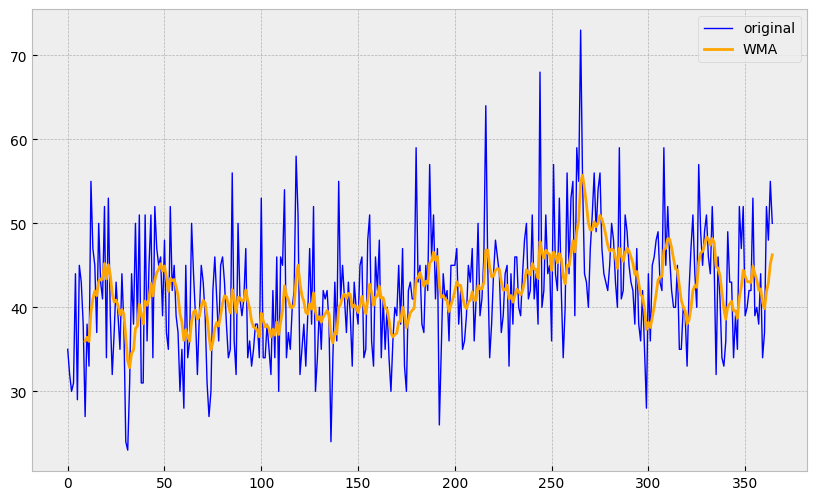

In [186]:
wma = weighted_moving_average(stat_ser, 10, [1,2,3,4,5,6,7,8,9,10])

with plt.style.context('bmh'):
    plt.figure(figsize=(10, 6))
    plt.plot(stat_ser, color='blue',linewidth='1',label='original')
    plt.plot(wma, color='orange', linewidth='2', label='WMA')
    plt.legend()

Проверим насколько хорошо модель справляется с предсказыванием 5 последних показаний с WMA на основе 10 событий

In [198]:
def wma_prediction(series, n, weights, n_pred):
    
    series_pred = series.copy()
    
    for i in range(n_pred):
        # Calculate the WMA for the last n values in the series
        wma = np.sum(weights * series_pred.iloc[-n:]) / np.sum(weights)
        # Add the WMA value to the series
        series_pred.loc[len(series_pred)] = wma
    # Return the predicted values
    return series_pred[-n_pred:]

In [196]:
y_true = stat_ser[-5:]
y_train = stat_ser[:-5]

weights = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
y_pred = wma_prediction(y_train, 10, weights, 5)


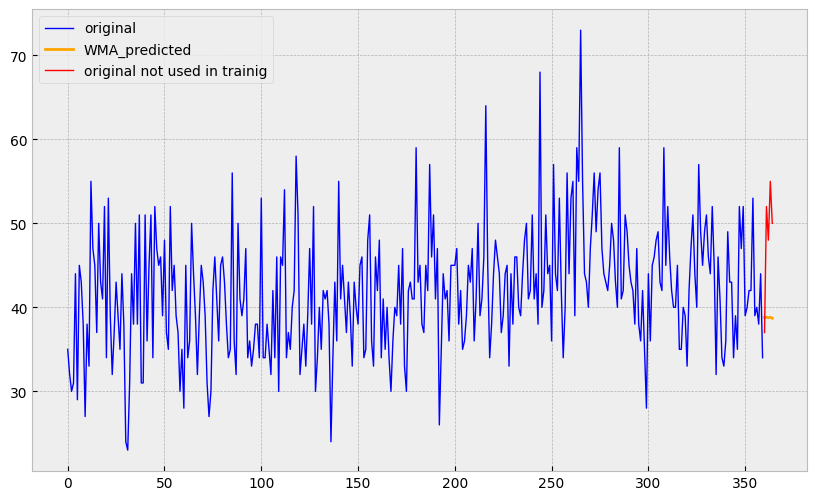

In [237]:
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 6))
    plt.plot(y_train, color='blue',linewidth='1',label='original')
    plt.plot(y_pred, color='orange', linewidth='2', label='WMA_predicted')
    plt.plot(y_true, color='red', linewidth='1', label='original not used in training')
    
    plt.legend()

оценим ошибку

In [231]:
rmse(y_true,y_pred)

47.57673

In [236]:
# попробуем разные веса и разный размер окна

weight_dict= {
    'seq': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'pow': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512],
    'fib': [0, 1, 1, 2, 3, 5, 8, 13, 21, 34],   
}

for key in weight_dict:
    y_true = stat_ser[-5:]
    y_train = stat_ser[:-5]
    for window in [2, 5,10]:
        weights = np.array(weight_dict[key])
        y_pred = wma_prediction(y_train, window, weights[:window], 5)
        print(key," windows:" ,window," - ", rmse(y_true,y_pred))

seq  windows: 2  -  59.53909
seq  windows: 5  -  53.53857
seq  windows: 10  -  47.57673
pow  windows: 2  -  59.53909
pow  windows: 5  -  55.38389
pow  windows: 10  -  54.18406
fib  windows: 2  -  72.0
fib  windows: 5  -  54.69174
fib  windows: 10  -  51.69303


In [262]:
# попробуем разные веса и разный размер окна, но предсказывать только следующее значение
# сделаем замер 300 раз и найдем среднее

weight_dict = {
    'seq': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'pow': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512],
    'fib': [0, 1, 1, 2, 3, 5, 8, 13, 21, 34],
}

for key in weight_dict:

    for window in [3, 7, 10]:
        
        weights = np.array(weight_dict[key])
        
        rmse_avg =[]
        for start_point in range(10, 310,1):
            y_train = stat_ser[:start_point]
            y_true = stat_ser[start_point:start_point+1]
            y_pred = wma_prediction(y_train, window, weights[:window], 1)
            rmse_avg.append(rmse(y_true, y_pred))
        print(key, " windows:", window, " - avg rmse", np.round(np.mean(rmse_avg),3))


seq  windows: 3  - avg rmse 6.446
seq  windows: 7  - avg rmse 6.008
seq  windows: 10  - avg rmse 5.833
pow  windows: 3  - avg rmse 6.487
pow  windows: 7  - avg rmse 6.311
pow  windows: 10  - avg rmse 6.3
fib  windows: 3  - avg rmse 6.705
fib  windows: 7  - avg rmse 6.187
fib  windows: 10  - avg rmse 6.127


Данный метод хорошо показывает себя на практике для предсказания небольшого количества шагов вперед. На текущих данных лучше всего показало себя предскказывание при последовательных весах

## Приближение нестационарного ряда моделями скользящего среднего

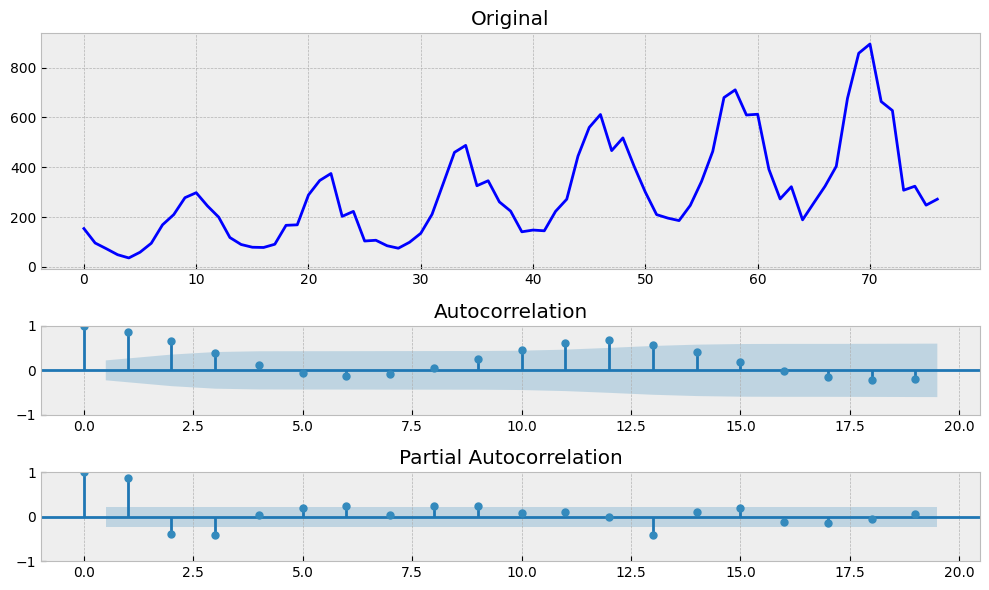

In [7]:
# Рассмотрим другой ряд. как мы знаем из прошлого дз, он нестационарный

non_stat_ser =non_stat_df.reset_index().iloc[:,-1]
tsplot(non_stat_ser)

В данном ряде видна четкая сезонность. Попробуем применить двойное экспоненциальное сглаживание

In [9]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

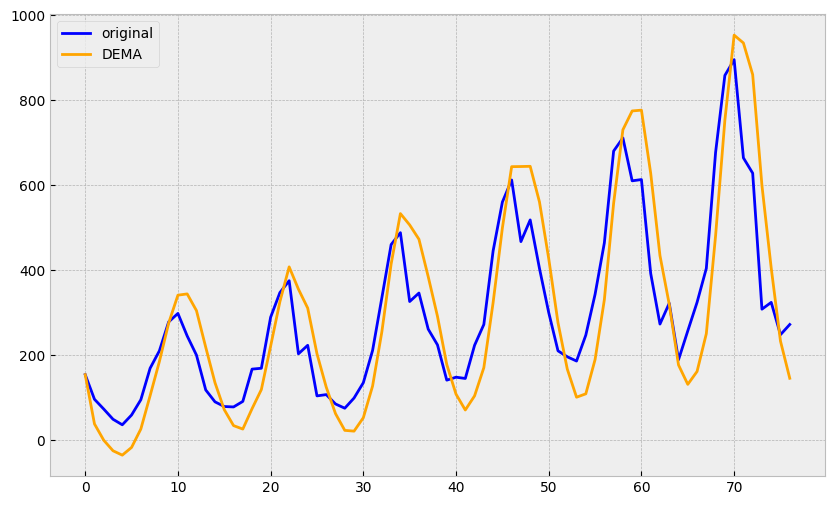

In [22]:
dema = double_ema(non_stat_ser, .4, .4)

with plt.style.context('bmh'):
    plt.figure(figsize=(10, 6))
    plt.plot(non_stat_ser,
             color='blue',
             linewidth='2',
             label='original')
    plt.plot(dema, color='orange', linewidth='2', label='DEMA')
    plt.legend()

Проверим насколько хорошо модель справляется с предсказыванием 5 последних показаний с DEMA 

In [23]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)

0.2 0.2 569.54001
0.2 0.8 2994.80305
0.8 0.2 1319.39259
0.8 0.8 494.72539
0.2 0.2 569.54001


C:\Users\RUEMSA\AppData\Local\Temp\ipykernel_2708\2601243732.py:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)


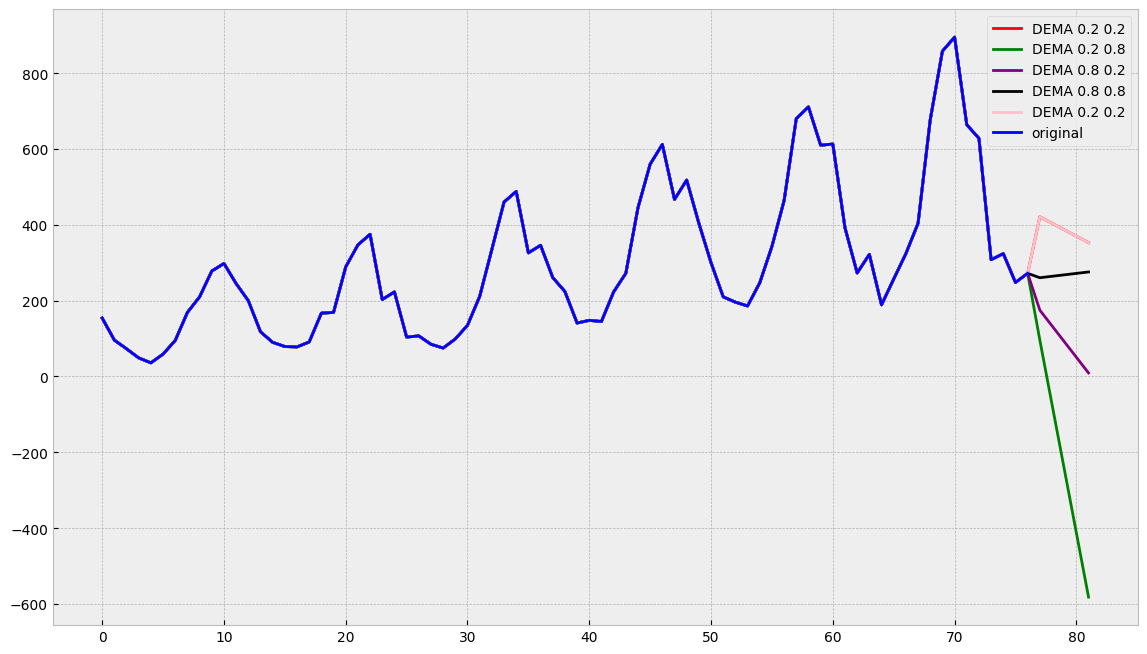

In [49]:
alphas = [0.2,0.2,0.8,0.8,0.2]
bettas = [0.2,0.8,0.2,0.8,0.2]
colors = ['red', 'green', 'purple', 'black','pink']


with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    y_true = non_stat_ser[-5:]
   
    for i in range(len(alphas)):
        ser, _ = double_ema_with_preds(non_stat_ser, alphas[i], bettas[i], 5)
        plt.plot(ser, color=colors[i], linewidth='2', label='DEMA {} {}'.format(alphas[i], bettas[i]))
        print(alphas[i], bettas[i], rmse(y_true,ser[-5:]))
    plt.plot(non_stat_ser, color='blue',label='original')
    plt.legend()

Данная модель хорошо сглаживает сезонные изменения. Данная модель быстрее и точнее реагирует на изменения, что важно в нестационарных моделях. Но предсказания на более долгий период в будущее здесь малоэффективны. по крайней мере в этом исполнении. возможно оптимизация позволит получить лучшие результаты